In [1]:
import pandas as pd
from statsmodels.stats.multitest import multipletests
from scipy.stats import ttest_ind

In [6]:
df = pd.read_csv('../files/dengue_full_rudi.csv')

# remove rows with missing gene names
df_clean = df[df['A - HGNC'].isnull() == False]
df_clean

,A - HGNC,B - Gene ID,C - UniProtID,D - Protein abundance 24 hours after infection vs mock control,E - Protein abundance 48 hours after infection vs mock control,"F - siRNA Screen Average Zscore (the higher the score, the stronger the negative effect on viral replication)",G - mRNA expression 24 hours after infection (log2FC_24hpi),H - mRNA expression 48 hours after infection (log2FC_48hpi),I - Dengue viral protein interacting with host protein,J - dengue_MiST_list
0,ZWILCH,55055,Q9H900,NaN,NaN,1.406935,NaN,NaN,ZIKVfp NS4A,0.647205918
1,ZSCAN9,7746,O15535,NaN,NaN,1.680725,NaN,NaN,NaN,NaN
2,ZSCAN16,80345,Q9H4T2,NaN,NaN,1.882438,NaN,NaN,NaN,NaN
3,ZSCAN10,84891,Q96SZ4,NaN,NaN,1.498169,NaN,NaN,NaN,NaN
4,ZNRF3,84133,Q9ULT6,NaN,NaN,1.363028,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2016,ABCB9,23457,Q9NP78,NaN,NaN,NaN,NaN,-2.021558,NaN,NaN
2017,ABCA2,20,Q9BZC7,NaN,NaN,NaN,NaN,-2.435633,NaN,NaN
2018,AAR2,25980,Q9Y312,NaN,NaN,1.493488,NaN,NaN,NaN,NaN
2019,AAGAB,79719,Q6PD74,NaN,NaN,1.644903,NaN,NaN,NaN,NaN


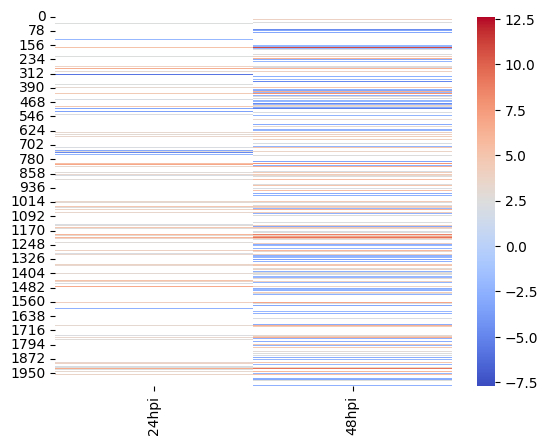

In [15]:
# plot heatmap of expression values
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(df_clean.loc[:, ['G - mRNA expression 24 hours after infection (log2FC_24hpi)', 'H - mRNA expression 48 hours after infection (log2FC_48hpi)']], cmap='coolwarm', annot=False)
plt.xticks(ticks=[0.5, 1.5], labels=['24hpi', '48hpi'])
plt.show()

In [18]:
# filter for DEGs
log2fc = 2

DEG_24hr = df_clean[(df_clean['G - mRNA expression 24 hours after infection (log2FC_24hpi)'].abs() >= log2fc)]
DEG_24hr_up = DEG_24hr[DEG_24hr['G - mRNA expression 24 hours after infection (log2FC_24hpi)'] >= log2fc]
DEG_24hr_down = DEG_24hr[DEG_24hr['G - mRNA expression 24 hours after infection (log2FC_24hpi)'] <= -log2fc]
DEG_48hr = df_clean[(df_clean['H - mRNA expression 48 hours after infection (log2FC_48hpi)'].abs() >= log2fc)]
DEG_48hr_up = DEG_48hr[DEG_48hr['H - mRNA expression 48 hours after infection (log2FC_48hpi)'] >= log2fc]
DEG_48hr_down = DEG_48hr[DEG_48hr['H - mRNA expression 48 hours after infection (log2FC_48hpi)'] <= -log2fc]


print(f'Number of DEGs at 24hpi: {DEG_24hr.shape[0]}')
print(f'Number of DEGs at 48hpi: {DEG_48hr.shape[0]}')
print(f'Number of upregulated DEGs at 24hpi: {DEG_24hr_up.shape[0]}')
print(f'Number of downregulated DEGs at 24hpi: {DEG_24hr_down.shape[0]}')
print(f'Number of upregulated DEGs at 48hpi: {DEG_48hr_up.shape[0]}')
print(f'Number of downregulated DEGs at 48hpi: {DEG_48hr_down.shape[0]}')

Number of DEGs at 24hpi: 322
Number of DEGs at 48hpi: 880
Number of upregulated DEGs at 24hpi: 275
Number of downregulated DEGs at 24hpi: 47
Number of upregulated DEGs at 48hpi: 556
Number of downregulated DEGs at 48hpi: 324


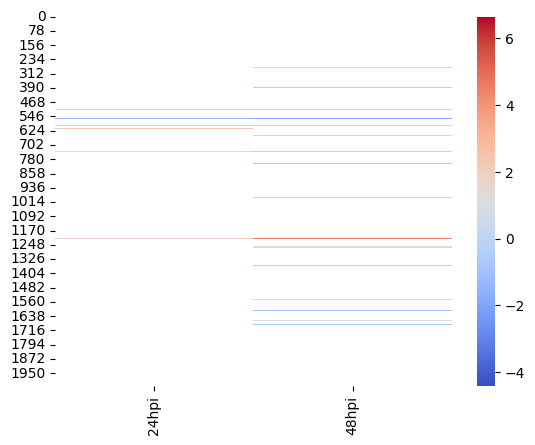

In [19]:
# plot heatmap of protein abundance values
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(df_clean.loc[:, ['D - Protein abundance 24 hours after infection vs mock control', 'E - Protein abundance 48 hours after infection vs mock control']], cmap='coolwarm', annot=False)
plt.xticks(ticks=[0.5, 1.5], labels=['24hpi', '48hpi'])
plt.show()

In [ ]:
# filter for DEPs
